In [2]:
import numpy as np
from src.stimuli_generation import draw_and_save_circle
import os
import time

ModuleNotFoundError: No module named 'src.stimuli_generation'

# Generate stimuli

In [ ]:
data_dir = '../data/circle_shade_radius_stimuli'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
shades = list(np.arange(-1, 1.01, 0.01))
radius = list(np.arange(0, 1.01, 0.01))
start_time = time.time()
draw_and_save_circle(data_dir, shades, radius)
print('It took {} seconds to generate stimuli'.format(time.time()-start_time))

2.7304 	WARNING 	Monitor specification not found. Creating a temporary one...
153.9579 	WARNING 	Monitor specification not found. Creating a temporary one...
156.3080 	WARNING 	Couldn't measure a consistent frame rate.
  - Is your graphics card set to sync to vertical blank?
  - Are you running other processes on your computer?

156.3700 	WARNING 	t of last frame was 62.17ms (=1/16)
156.4208 	WARNING 	t of last frame was 50.86ms (=1/19)
156.4677 	WARNING 	t of last frame was 46.83ms (=1/21)
156.5353 	WARNING 	t of last frame was 67.64ms (=1/14)
156.6078 	WARNING 	Multiple dropped frames have occurred - I'll stop bothering you about them!
1379.9578 	WARNING 	Desired color [1. 1. 1.] (in RGB 0->1 units) falls outside the monitor gamut. Drawing blue instead
1379.9855 	WARNING 	Desired color [1. 1. 1.] (in RGB 0->1 units) falls outside the monitor gamut. Drawing blue instead
1380.0133 	WARNING 	Desired color [1. 1. 1.] (in RGB 0->1 units) falls outside the monitor gamut. Drawing blue inste

# Cleaning up images with radius == 0 and shade > 1

In [ ]:
import shutil

In [ ]:
move_data_dir = '../data/invalid_files'
data_dir = '../data/circle_shade_radius_stimuli'
if not os.path.exists(move_data_dir):
    os.mkdir(move_data_dir)
for img in os.listdir(data_dir):
    temp = img.split('_')
    try:
        shade = float(temp[1])
    except:
        print(shade, type(shade), img)
    try:
        radii = float(temp[-1].split('.png')[0])
    except:
        print(radii, type(radii), img) 
    if shade >1 or radii ==0:
        shutil.move(os.path.join(data_dir, img), os.path.join(move_data_dir, img))

-0.49999999999999956 <class 'float'> .DS_Store
1.0 <class 'float'> .DS_Store


# Classifier

In [3]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
class UnfairClassifierParametric(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(UnfairClassifierParametric, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, size, shade):
        output = shade*(torch.sigmoid(self.linear(size))) + (1-shade)*(0.5)
        return output

In [5]:
data_dir = '../data/circle_shade_radius_stimuli'
x = []
y = []
for img in os.listdir(data_dir):
    temp = img.split('_')
    try:
        shade = float(temp[1])
    except:
        print(shade, type(shade), img)
    try:
        radii = float(temp[-1].split('.png')[0])
    except:
        print(radii, type(radii), img) 
    x.append([radii, shade])
    if radii>0.5:
        y.append(1)
    else:
        y.append(0)

-0.49999999999999956 <class 'float'> .DS_Store
1.0 <class 'float'> .DS_Store


In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(x), np.asarray(y), test_size=0.33, random_state=42)
X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

X_train_size = X_train[:, 0].unsqueeze(1)
X_train_shade = X_train[:, 1].unsqueeze(1)
assert(X_train_shade.shape == X_train_size.shape)

X_test_size = X_test[:, 0].unsqueeze(1)
X_test_shade = X_test[:, 1].unsqueeze(1)
assert(X_test_size.shape == X_test_shade.shape)

In [20]:
epochs = 200000
input_dim = 1 # Only size needs to be used to see if something is big or small
output_dim = 1 # big or small, binary
learning_rate = 0.01
classifier = UnfairClassifierParametric(1, 1)
optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()
# dummy_data_size = torch.tensor([[1.0], [3.0]])
# dummy_data_shade =torch.tensor([[2.0], [4.0]])
# print(classifier(dummy_data_size, dummy_data_shade))

In [21]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    classifier.train()
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = classifier(X_train_size, X_train_shade)
    loss = criterion(torch.squeeze(outputs), labels) 
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%10000==0:
        with torch.no_grad():
            classifier.eval()
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(classifier(X_test_size, X_test_shade))
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:   5%|▌         | 10537/200000 [00:02<00:52, 3582.07it/s]

Iteration: 10000. 
Test - Loss: 0.6933409571647644. Accuracy: 50.59839418269959
Train -  Loss: 0.6940019130706787. Accuracy: 49.440298507462686



Training Epochs:  10%|█         | 20735/200000 [00:05<00:45, 3943.52it/s]

Iteration: 20000. 
Test - Loss: 0.6932986974716187. Accuracy: 49.47735191637631
Train -  Loss: 0.6932786107063293. Accuracy: 50.24626865671642



Training Epochs:  15%|█▌        | 30701/200000 [00:08<00:42, 3955.81it/s]

Iteration: 30000. 
Test - Loss: 0.6934551000595093. Accuracy: 49.44705347674595
Train -  Loss: 0.6930328607559204. Accuracy: 50.276119402985074



Training Epochs:  20%|██        | 40629/200000 [00:10<00:43, 3667.78it/s]

Iteration: 40000. 
Test - Loss: 0.6936073899269104. Accuracy: 49.416755037115585
Train -  Loss: 0.692949652671814. Accuracy: 50.492537313432834



Training Epochs:  25%|██▌       | 50480/200000 [00:13<00:41, 3604.31it/s]

Iteration: 50000. 
Test - Loss: 0.6937168836593628. Accuracy: 49.05317376155128
Train -  Loss: 0.6929214000701904. Accuracy: 50.71641791044776



Training Epochs:  30%|███       | 60609/200000 [00:16<00:39, 3564.12it/s]

Iteration: 60000. 
Test - Loss: 0.693787693977356. Accuracy: 48.9622784426602
Train -  Loss: 0.6929118037223816. Accuracy: 50.78358208955224



Training Epochs:  35%|███▌      | 70691/200000 [00:19<00:36, 3526.74it/s]

Iteration: 70000. 
Test - Loss: 0.6938313245773315. Accuracy: 48.977427662475385
Train -  Loss: 0.6929086446762085. Accuracy: 50.78358208955224



Training Epochs:  40%|████      | 80355/200000 [00:21<00:33, 3531.80it/s]

Iteration: 80000. 
Test - Loss: 0.6938575506210327. Accuracy: 48.85623390395395
Train -  Loss: 0.6929073929786682. Accuracy: 50.850746268656714



Training Epochs:  45%|████▌     | 90586/200000 [00:24<00:31, 3469.27it/s]

Iteration: 90000. 
Test - Loss: 0.6938731670379639. Accuracy: 48.85623390395395
Train -  Loss: 0.6929070949554443. Accuracy: 50.850746268656714



Training Epochs:  50%|█████     | 100480/200000 [00:27<00:29, 3390.48it/s]

Iteration: 100000. 
Test - Loss: 0.6938823461532593. Accuracy: 48.85623390395395
Train -  Loss: 0.6929069757461548. Accuracy: 50.850746268656714



Training Epochs:  55%|█████▌    | 110423/200000 [00:30<00:25, 3504.09it/s]

Iteration: 110000. 
Test - Loss: 0.6938877701759338. Accuracy: 48.81078624450841
Train -  Loss: 0.6929069757461548. Accuracy: 50.88059701492537



Training Epochs:  60%|██████    | 120410/200000 [00:33<00:22, 3534.54it/s]

Iteration: 120000. 
Test - Loss: 0.6938908696174622. Accuracy: 48.81078624450841
Train -  Loss: 0.6929068565368652. Accuracy: 50.88059701492537



Training Epochs:  65%|██████▌   | 130381/200000 [00:36<00:19, 3509.89it/s]

Iteration: 130000. 
Test - Loss: 0.6938927173614502. Accuracy: 48.81078624450841
Train -  Loss: 0.6929068565368652. Accuracy: 50.88059701492537



Training Epochs:  70%|███████   | 140368/200000 [00:38<00:16, 3561.54it/s]

Iteration: 140000. 
Test - Loss: 0.6938937902450562. Accuracy: 48.81078624450841
Train -  Loss: 0.6929067969322205. Accuracy: 50.88059701492537



Training Epochs:  75%|███████▌  | 150290/200000 [00:42<00:17, 2778.42it/s]

Iteration: 150000. 
Test - Loss: 0.6938943266868591. Accuracy: 48.81078624450841
Train -  Loss: 0.6929068565368652. Accuracy: 50.88059701492537



Training Epochs:  80%|████████  | 160567/200000 [00:45<00:11, 3476.56it/s]

Iteration: 160000. 
Test - Loss: 0.6938948035240173. Accuracy: 48.81078624450841
Train -  Loss: 0.6929068565368652. Accuracy: 50.88059701492537



Training Epochs:  85%|████████▌ | 170633/200000 [00:48<00:09, 3244.39it/s]

Iteration: 170000. 
Test - Loss: 0.6938949227333069. Accuracy: 48.81078624450841
Train -  Loss: 0.6929068565368652. Accuracy: 50.88059701492537



Training Epochs:  90%|█████████ | 180564/200000 [00:52<00:05, 3504.89it/s]

Iteration: 180000. 
Test - Loss: 0.6938949227333069. Accuracy: 48.81078624450841
Train -  Loss: 0.6929068565368652. Accuracy: 50.88059701492537



Training Epochs:  95%|█████████▌| 190612/200000 [00:55<00:02, 3514.72it/s]

Iteration: 190000. 
Test - Loss: 0.6938949227333069. Accuracy: 48.81078624450841
Train -  Loss: 0.6929068565368652. Accuracy: 50.88059701492537



Training Epochs: 100%|██████████| 200000/200000 [00:57<00:00, 3465.07it/s]

Iteration: 200000. 
Test - Loss: 0.6938949227333069. Accuracy: 48.81078624450841
Train -  Loss: 0.6929068565368652. Accuracy: 50.88059701492537



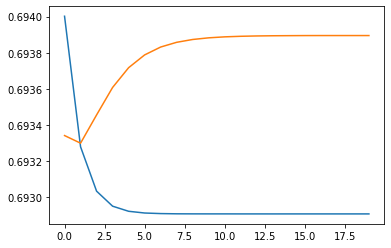

In [22]:
plt.plot(losses)
plt.plot(losses_test)

In [35]:
# high shade
X_test[X_test[:, 1]>0].shape

# low shade
X_test[X_test[:, 1]<0].shape

torch.Size([3234, 2])

In [36]:
def evaluate_classifier(classifier, X_test, y_test):
    with torch.no_grad():
        classifier.eval()
        # Calculating the loss and accuracy for the test dataset
        correct_test = 0
        total_test = 0
        X_test_size = X_test[:, 0].unsqueeze(1)
        X_test_shade = X_test[:, 1].unsqueeze(1)
        outputs_test = torch.squeeze(classifier(X_test_size, X_test_shade))
        loss_test = criterion(outputs_test, y_test)
        
        predicted_test = outputs_test.round().detach().numpy()
        total_test += y_test.size(0)
        correct_test += np.sum(predicted_test == y_test.detach().numpy())
        accuracy_test = 100 * correct_test/total_test
        return accuracy_test

print('high shade accuracy is ', evaluate_classifier(classifier, X_test[X_test[:, 1]>0], y_test[X_test[:, 1]>0]))
print('low shade accuracy is ', evaluate_classifier(classifier, X_test[X_test[:, 1]<0], y_test[X_test[:, 1]<0]))

high shade accuracy is  10.95931095931096
low shade accuracy is  88.21892393320965
